# MLP for just the first cases

In [169]:
import torch 
import pandas as pd 
import pickle
import numpy as np
import os
import sys 

from torch.utils.data import Dataset, DataLoader
from torch import nn
import torch.nn.functional as F
import torch.optim as optim


import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
from tqdm import trange

sns.set_theme()

In [170]:
# Load data
freq_data = np.genfromtxt(r"FLAC\FLAC2D\1D Multiple columns\TTF_freq.csv")

# Load pickle
with open(r"FLAC\FLAC2D\1D Multiple columns\Results\TTF_data.pt", "rb") as f:
    TTF_data = pickle.load(f)

with open(r"FLAC\FLAC2D\1D Multiple columns\Results\Vs_values.pt", "rb") as f:
    Vs_data = pickle.load(f)

TTF_data = np.array(TTF_data)
Vs_data = np.array(Vs_data)

print(TTF_data.shape, Vs_data.shape)


(500, 256) (500, 30)


In [171]:
from scipy.interpolate import interp1d

# Interpolate data
f = interp1d(freq_data, TTF_data, axis=1)

freq_data_2 = np.linspace(np.min(freq_data), np.max(freq_data), 1000)

TTF_data_2 = f(freq_data_2)

print(TTF_data_2.shape, freq_data_2.shape)

(500, 1000) (1000,)


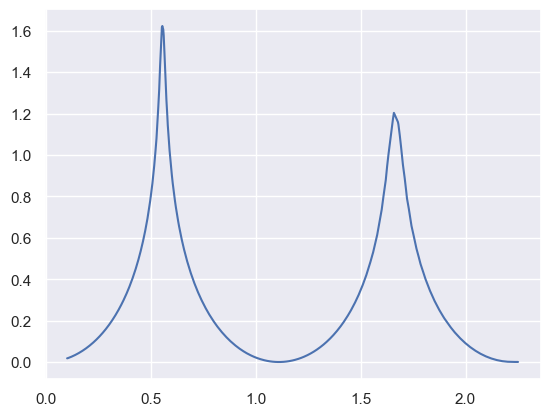

In [172]:
from sklearn.preprocessing import MaxAbsScaler

#scaler = MaxAbsScaler()
#TTF_values = scaler.fit_transform(TTF_data.T).T
#print(TTF_values.shape)

TTF_values = np.log10(TTF_data_2)

plt.plot(freq_data_2, TTF_values[9,:], label="TTF")

In [174]:
class TTF_dataset(Dataset):
    def __init__(self, TTF_values, Vs_values):
        self.TTF_values = TTF_values
        self.Vs_values = Vs_values
        
    def __len__(self):
        return len(self.TTF_values)
    
    def __getitem__(self, idx):

        input_data = self.Vs_values[idx]
        input_data = torch.tensor(input_data, dtype=torch.float32).unsqueeze(0)

        target_data = self.TTF_values[idx]
        target_data = torch.tensor(target_data, dtype=torch.float32)
        return input_data, target_data

In [175]:
dataset = TTF_dataset(TTF_values, Vs_data)

# Separate into training and testing
train_size = int(0.8 * len(dataset))
val_size = (len(dataset) - train_size) // 2
test_size = len(dataset) - train_size - val_size
print("Train, validation and test sizes: " ,train_size, val_size, test_size)

train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])

batch_size = 100
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
print("Number of batches: ", len(train_loader), len(val_loader), len(test_loader))

Train, validation and test sizes:  400 50 50
Number of batches:  4 1 1


# Model

In [176]:
# Create Model
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, hidden_layers, output_dim=1, activation=nn.ReLU, batch_norm=False):
        super(MLP, self).__init__()
        self.hidden_layers = nn.ModuleList()
        self.batch_norm = batch_norm
        self.activation = activation
        self.output_dim = output_dim

        # Input layer
        self.hidden_layers.append(nn.Linear(input_dim, hidden_dim))
        if self.batch_norm:
            self.hidden_layers.append(nn.BatchNorm1d(hidden_dim))

        # Hidden layers
        for _ in range(hidden_layers - 1):
            self.hidden_layers.append(nn.Linear(hidden_dim, hidden_dim))
            if self.batch_norm:
                self.hidden_layers.append(nn.BatchNorm1d(hidden_dim))

        # Output layer
        self.out = nn.Linear(hidden_dim, output_dim)


    def forward(self, x):
        for layer in self.hidden_layers:
            if isinstance(layer, nn.Linear):
                x = layer(x)
                x = self.activation()(x)
            elif isinstance(layer, nn.BatchNorm1d):
                x = layer(x)
        x = self.out(x)
        return x

In [177]:
class CNN_1D(nn.Module):
    def __init__(self, input_size, kernel_size, hidden_dim, hidden_layers, output_dim=1, activation=nn.ReLU):
        super(CNN_1D, self).__init__()
        self.hidden_layers = nn.ModuleList()
        self.activation = activation
        self.output_dim = output_dim

        # Input layer
        self.hidden_layers.append(nn.Conv1d(input_size, hidden_dim, kernel_size))
        self.hidden_layers.append(nn.MaxPool1d(2))

        # Additional hidden layers
        for _ in range(hidden_layers - 1):
            self.hidden_layers.append(nn.Conv1d(hidden_dim, hidden_dim, kernel_size))
            self.hidden_layers.append(nn.MaxPool1d(2))

        # Adaptive pooling layer to reduce sequence length to 1
        self.hidden_layers.append(nn.AdaptiveAvgPool1d(1))

    def forward(self, x):
        for layer in self.hidden_layers:
            x = layer(x)
            x = self.activation()(x)
        return x

In [178]:
# Let's do a RNN model
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, x, device="cpu"):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        out, _ = self.rnn(x, h0)   
        out = self.fc(out[:, -1, :])
        return out  

In [179]:
# Sequence-to-sequence model
# Encoder RNN
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, h1 = self.gru(x, h0)
        return out, h1

# Decoder RNN
class DecoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)

    def forward(self, x, hidden):
        outputs, hidden = self.rnn(x, hidden)
        return outputs, hidden

In [180]:
class Attention(nn.Module):
    def __init__(self, hidden_size):
        super(Attention, self).__init__()
        self.attn = nn.Linear(hidden_size * 2, hidden_size)
        self.v = nn.Parameter(torch.rand(hidden_size))

    def forward(self, hidden, encoder_outputs):
        timestep = encoder_outputs.size(1)
        h = hidden.repeat(timestep, 1, 1).transpose(0, 1)
        attn_energies = self.score(h, encoder_outputs)
        return F.softmax(attn_energies, dim=1)

    def score(self, hidden, encoder_outputs):
        energy = torch.tanh(self.attn(torch.cat([hidden, encoder_outputs], 2)))
        energy = energy.transpose(2, 1)
        v = self.v.repeat(encoder_outputs.size(0), 1).unsqueeze(1)
        energy = torch.bmm(v, energy)
        return energy.squeeze(1)

In [181]:
class DecoderRNNWithAttention(nn.Module):
    def __init__(self, hidden_size, num_layers):
        super(DecoderRNNWithAttention, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.RNN(hidden_size * 2, hidden_size, num_layers, batch_first=True)
        self.attention = Attention(hidden_size)

    def forward(self, x, hidden, encoder_outputs):
        attn_weights = self.attention(hidden[-1], encoder_outputs)
        context = attn_weights.unsqueeze(1).bmm(encoder_outputs)
        rnn_input = torch.cat([x, context], 2)
        outputs, hidden = self.rnn(rnn_input, hidden)
        return outputs, hidden

In [182]:
# Define the Encoder LSTM
class EncoderLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(EncoderLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, (h1, c1) = self.lstm(x, (h0, c0))
        return out, (h1, c1)

class DecoderLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(DecoderLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)

    def forward(self, x, hidden):
        outputs, (hidden, cell) = self.lstm(x, hidden)
        return outputs, (hidden, cell)

# Define the Decoder LSTM with Attention
class DecoderLSTMWithAttention(nn.Module):
    def __init__(self, hidden_size, output_size, num_layers):
        super(DecoderLSTMWithAttention, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(hidden_size * 2, hidden_size, num_layers, batch_first=True)
        self.attention = Attention(hidden_size)

    def forward(self, x, hidden, encoder_outputs):
        h1, c1 = hidden
        attn_weights = self.attention(h1[-1], encoder_outputs)
        context = attn_weights.unsqueeze(1).bmm(encoder_outputs)
        lstm_input = torch.cat([x, context], 2)
        outputs, (hidden, cell) = self.lstm(lstm_input, hidden)
        return outputs, (hidden, cell)


In [183]:
class EncoderGRU(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(EncoderGRU, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)

    def forward(self, x):
        outputs, hidden = self.gru(x)
        return outputs, hidden


class DecoderGRU(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(DecoderGRU, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)

    def forward(self, x, hidden):
        outputs, hidden = self.gru(x, hidden)
        return outputs, hidden

class DecoderGRUWithAttention(nn.Module):
    def __init__(self, hidden_size, num_layers):
        super(DecoderGRUWithAttention, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.gru = nn.GRU(hidden_size * 2, hidden_size, num_layers, batch_first=True)
        self.attention = Attention(hidden_size)

    def forward(self, x, hidden, encoder_outputs):
        attn_weights = self.attention(hidden[-1], encoder_outputs)
        context = attn_weights.unsqueeze(1).bmm(encoder_outputs)
        gru_input = torch.cat([x, context], 2)
        outputs, hidden = self.gru(gru_input, hidden)
        return outputs, hidden

In [184]:
class EncoderBiLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(EncoderBiLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.bidirectional = True
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True)

    def forward(self, x):
        outputs, (hidden, cell) = self.lstm(x)
        # Concatenate the hidden states from both directions
        hidden = self._cat_directions(hidden)
        cell = self._cat_directions(cell)
        return outputs, (hidden, cell)

    def _cat_directions(self, h):
        # [num_layers * num_directions, batch, hidden_size] -> [num_layers, batch, hidden_size * num_directions]
        h = torch.cat([h[0:h.size(0):2], h[1:h.size(0):2]], dim=2)
        return h

class DecoderBiLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(DecoderBiLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)

    def forward(self, x, hidden):
        outputs, (hidden, cell) = self.lstm(x, hidden)
        return outputs, (hidden, cell)

class DecoderBiLSTMwithAttention(nn.Module):
    def __init__(self, hidden_size, num_layers):
        super(DecoderBiLSTMwithAttention, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(hidden_size * 2, hidden_size, num_layers, batch_first=True)
        self.attention = Attention(hidden_size)

    def forward(self, x, hidden, encoder_outputs):
        h1, c1 = hidden
        attn_weights = self.attention(h1[-1], encoder_outputs)
        context = attn_weights.unsqueeze(1).bmm(encoder_outputs)
        lstm_input = torch.cat([x, context], 2)
        outputs, (hidden, cell) = self.lstm(lstm_input, hidden)
        return outputs, (hidden, cell)

In [185]:
class EncoderBiGRU(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(EncoderBiGRU, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.bidirectional = True
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True)

    def forward(self, x):
        outputs, hidden = self.gru(x)
        # Concatenate the hidden states from both directions
        hidden = self._cat_directions(hidden)
        return outputs, hidden

    def _cat_directions(self, h):
        # [num_layers * num_directions, batch, hidden_size] -> [num_layers, batch, hidden_size * num_directions]
        h = torch.cat([h[0:h.size(0):2], h[1:h.size(0):2]], dim=2)
        return h

class DecoderBiGRU(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(DecoderBiGRU, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)

    def forward(self, x, hidden):
        outputs, hidden = self.gru(x, hidden)
        return outputs, hidden

class DecoderBiGRUwithAttention(nn.Module):
    def __init__(self, hidden_size, num_layers):
        super(DecoderBiGRUwithAttention, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.gru = nn.GRU(hidden_size * 2, hidden_size, num_layers, batch_first=True)
        self.attention = Attention(hidden_size)

    def forward(self, x, hidden, encoder_outputs):
        attn_weights = self.attention(hidden[-1], encoder_outputs)
        context = attn_weights.unsqueeze(1).bmm(encoder_outputs)
        gru_input = torch.cat([x, context], 2)
        outputs, hidden = self.gru(gru_input, hidden)
        return outputs, hidden
        

In [186]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, mlp, cnn_1d=None):
        super(Seq2Seq, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.mlp = mlp
        self.cnn_1d = cnn_1d

    def forward(self, x, device="cpu", print_shapes=False):
        if print_shapes:
            print("Input shape: ", x.shape)

        if self.cnn_1d:
            x = self.cnn_1d(x)
            if print_shapes:
                print("CNN output shape: ", x.shape)
        
        encoder_outputs, hidden = self.encoder(x)
        if print_shapes:
            print("Encoder outputs shape: ", encoder_outputs.shape)
            print("Hidden state shape: ", hidden[0].shape)  # Print hidden state
            print("Cell state shape: ", hidden[1].shape)    # Print cell state
        
        # Adjust decoder input to match encoder hidden size
        if hasattr(self.encoder, 'bidirectional') and self.encoder.bidirectional:
            decoder_input_size = self.encoder.hidden_size * 2
        else:
            decoder_input_size = self.encoder.hidden_size

        decoder_input = torch.zeros(x.size(0), 1, decoder_input_size).to(device)

        if print_shapes:
            print("Decoder input shape: ", decoder_input.shape)
        
        if hasattr(self.decoder, 'attention'):
            output, hidden = self.decoder(decoder_input, hidden, encoder_outputs)
        else:
            output, hidden = self.decoder(decoder_input, hidden)
        
        if print_shapes:
            print("Decoder output shape: ", output.shape)
        
        output = self.mlp(output)

        if print_shapes:
            print("MLP output shape: ", output.shape)
        
        return output.squeeze(1)

In [187]:
# CNN Hyperparameters
input_size_cnn = 1
kernel_size = 3
hidden_dim_cnn = 60
hidden_layers_cnn = 2

# Encoder and Decoder hyperparameters
input_size = 1 # Given the size of [batch_size, sequence_length, input_size] 
hidden_size = 60
num_layers = 6

# MLP hyperparameters
num_layers_fc = 2
hidden_size_fc = 500
output_size = 1000

# Check bidirectional


# Model
cnn_1d = CNN_1D(input_size_cnn, kernel_size, hidden_dim_cnn, hidden_layers_cnn)
encoder = EncoderLSTM(input_size, hidden_size, num_layers)
if hasattr(encoder, 'bidirectional') and encoder.bidirectional:
    hidden_size *= 2
decoder = DecoderLSTM(hidden_size, hidden_size, num_layers)
mlp = MLP(hidden_size, hidden_size_fc, num_layers_fc, output_size)

model = Seq2Seq(encoder, decoder, mlp, cnn_1d)

In [188]:
# Check if the model works
X, y = next(iter(train_loader))
print("Input shape: ", X.shape, "Output shape: ", y.shape)
loss_fn = nn.MSELoss()
output = model(X, print_shapes=True)
print("Model output shape: ", output.shape)
assert output.shape == y.shape, "Expected output shape to be the same as target shape"
print(loss_fn(output, y))

Input shape:  torch.Size([100, 1, 30]) Output shape:  torch.Size([100, 1000])
Input shape:  torch.Size([100, 1, 30])
CNN output shape:  torch.Size([100, 60, 1])
Encoder outputs shape:  torch.Size([100, 60, 60])
Hidden state shape:  torch.Size([6, 100, 60])
Cell state shape:  torch.Size([6, 100, 60])
Decoder input shape:  torch.Size([100, 1, 60])
Decoder output shape:  torch.Size([100, 1, 60])
MLP output shape:  torch.Size([100, 1, 1000])
Model output shape:  torch.Size([100, 1000])
tensor(0.2185, grad_fn=<MseLossBackward0>)


In [189]:
# Early stopping
class EarlyStopping():
    def __init__(self, patience=5, delta=0.0, progress_bar=None):
        self.patience = patience
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.delta = delta
        self.progress_bar = progress_bar

    def __call__(self, val_loss, model):
        if self.best_score is None:
            self.best_score = val_loss
        elif val_loss > self.best_score + self.delta:
            self.counter += 1
            if self.progress_bar:
                self.progress_bar.set_postfix_str(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = val_loss
            self.counter = 0
            if self.progress_bar:
                self.progress_bar.set_postfix_str('')

In [190]:
from tqdm import trange, tqdm

def train_model(model, optimizer, scheduler, train_dataloader, validation_dataloader, loss_fn, epochs=100, device="cpu", 
patience=50, clipping=True, print_epoch=10):
    """
    Train a PyTorch model with early stopping and learning rate scheduler.
    
    Args:
    model: PyTorch model
    optimizer: PyTorch optimizer
    scheduler: PyTorch learning rate scheduler
    train_dataloader: PyTorch DataLoader for training data
    validation_dataloader: PyTorch DataLoader for validation data
    loss_fn: PyTorch loss function
    epochs: Number of epochs to train
    device: PyTorch device, e.g. "cpu" or "cuda"
    patience: Patience for early stopping, i.e. number of epochs without improvement before stopping
    clipping: Whether to use gradient clipping
    print_epoch: Print training and validation loss every print_epoch epochs

    Returns:
    train_losses: List of training losses
    val_losses: List of validation losses
    model: Trained PyTorch model
    """
    
    train_losses = []
    val_losses = []
    model.to(device)
    progress_bar = tqdm(range(epochs), desc="Training", unit="epoch")
    early_stopping = EarlyStopping(patience=patience, progress_bar=progress_bar)
    best_model = None

    for epoch in progress_bar:
        model.train()
        train_loss = 0
        for X, y in train_dataloader:
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            y_pred = model(X, device)
            loss = loss_fn(y_pred, y)
            loss.backward()
            if clipping:
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Gradient clipping
            optimizer.step()
            train_loss += loss.item()
        train_loss /= len(train_dataloader)
        train_losses.append(train_loss)

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for X, y in validation_dataloader:
                X, y = X.to(device), y.to(device)
                y_pred = model(X, device)
                loss = loss_fn(y_pred, y)
                val_loss += loss.item()
        val_loss /= len(validation_dataloader)
        val_losses.append(val_loss)

        if early_stopping is not None:
            early_stopping(val_loss, model)
            if early_stopping.early_stop:
                print("Early stopping")
                break

        if scheduler is not None:
            scheduler.step(val_loss)

        if epoch % print_epoch == 0:
            print(f"Epoch {epoch}, Train Loss: {train_loss}, Val Loss: {val_loss}, LR: {optimizer.param_groups[0]['lr']}")

        # Stop if loss is nan
        if np.isnan(train_loss) or np.isnan(val_loss):
            print("Loss is nan")
            break

    return train_losses, val_losses, model


def test_model(model, test_dataloader, loss_fn, device="cpu"):
    """
    Test a PyTorch model.
    Args:
    model: PyTorch model
    test_dataloader: PyTorch DataLoader for test data
    loss_fn: PyTorch loss function
    device: PyTorch device, e.g. "cpu" or "cuda"
    Returns:
    test_loss: Average test loss
    """
    
    model.eval()
    test_loss = 0
    for X, y in test_dataloader:
        X, y = X.to(device), y.to(device)
        y_pred = model(X, device)
        loss = loss_fn(y_pred, y)
        test_loss += loss.item()
    test_loss /= len(test_dataloader)
    return test_loss

In [191]:
# Optimizer
optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4, amsgrad=True, eps=1e-08, betas=(0.9, 0.999))

# Scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=900, 
threshold_mode='rel', cooldown=0, min_lr=1e-5, eps=1e-08)

# Training
num_epochs = 20000
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device: ", device)

# RMSE
def rmse(y_true, y_pred):
    return torch.sqrt(torch.mean((y_true - y_pred) ** 2))

loss_fn = nn.L1Loss()

Device:  cuda


In [192]:
train_losses, val_losses, model = train_model(model, optimizer, scheduler, train_loader, val_loader, loss_fn, 
epochs=num_epochs, device=device, patience=3000, clipping=True, print_epoch=1000)

Training:   0%|          | 1/20000 [00:00<1:10:05,  4.76epoch/s]

Epoch 0, Train Loss: 0.33215656131505966, Val Loss: 0.3226598799228668, LR: 0.001


Training:   5%|▌         | 1002/20000 [03:56<1:08:15,  4.64epoch/s, EarlyStopping counter: 369 out of 3000]

Epoch 1000, Train Loss: 0.07321318611502647, Val Loss: 0.14944429695606232, LR: 0.001


Training:  10%|█         | 2002/20000 [07:45<37:30,  8.00epoch/s, EarlyStopping counter: 1369 out of 3000]  

Epoch 2000, Train Loss: 0.01609076256863773, Val Loss: 0.1448126584291458, LR: 0.0005


Training:  15%|█▌        | 3001/20000 [10:13<1:13:06,  3.88epoch/s, EarlyStopping counter: 2368 out of 3000]

Epoch 3000, Train Loss: 0.009901573183014989, Val Loss: 0.14746317267417908, LR: 0.00025


Training:  18%|█▊        | 3632/20000 [11:45<53:00,  5.15epoch/s, EarlyStopping counter: 3000 out of 3000]  

Early stopping


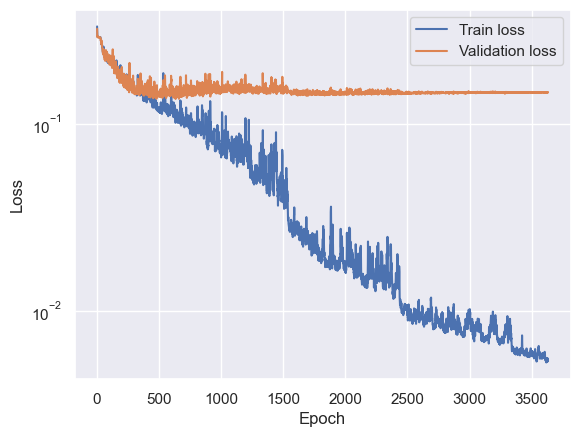

In [193]:
# Plot losses
plt.plot(train_losses, label="Train loss")
plt.plot(val_losses, label="Validation loss")
plt.yscale("log")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

In [194]:
# Test model    
test_loss = test_model(model, test_loader, loss_fn, device=device)
print("Test loss: ", test_loss)

Test loss:  0.18852855265140533


In [195]:
# Show results
model.eval()
target = []
predicted = []
Vs_data = []
with torch.no_grad():
    for X, y in test_loader:
        X, y = X.to(device), y.to(device)
        y_pred = model(X, device)
        target.append(y.cpu().numpy())
        predicted.append(y_pred.cpu().numpy())
        Vs_data.append(X.cpu().numpy())

target = np.concatenate(target)
predicted = np.concatenate(predicted)
Vs_data = np.concatenate(Vs_data)

print(target.shape, predicted.shape, Vs_data.shape)

(50, 1000) (50, 1000) (50, 1, 30)


In [196]:
# Get the correlation factor between target and predicted
from scipy.stats import pearsonr

for i in range(target.shape[0]):
    print("Correlation factor for TTF ", i,"and Vs ", str(np.unique(Vs_data[i,0])), " : ", pearsonr(target[i], predicted[i])[0])

Correlation factor for TTF  0 and Vs  [411.1111]  :  0.9999947266223197
Correlation factor for TTF  1 and Vs  [333.33334]  :  0.9999988780465876
Correlation factor for TTF  2 and Vs  [255.55556 488.8889 ]  :  0.7055635039087349
Correlation factor for TTF  3 and Vs  [333.33334 488.8889  722.2222 ]  :  0.9627859483257026
Correlation factor for TTF  4 and Vs  [566.6667 722.2222]  :  0.9911042157512266
Correlation factor for TTF  5 and Vs  [100.     566.6667 722.2222]  :  0.5814986025843609
Correlation factor for TTF  6 and Vs  [333.33334]  :  0.9999988780465876
Correlation factor for TTF  7 and Vs  [411.1111]  :  0.9999947266223197
Correlation factor for TTF  8 and Vs  [411.1111 488.8889]  :  0.8810655060981389
Correlation factor for TTF  9 and Vs  [100.      333.33334]  :  0.45718176558319357
Correlation factor for TTF  10 and Vs  [800.]  :  0.999999810098366
Correlation factor for TTF  11 and Vs  [333.33334 411.1111  488.8889 ]  :  0.7860759330088882
Correlation factor for TTF  12 and V

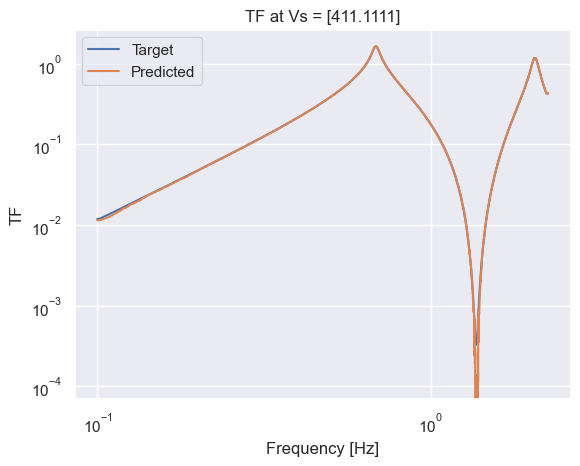

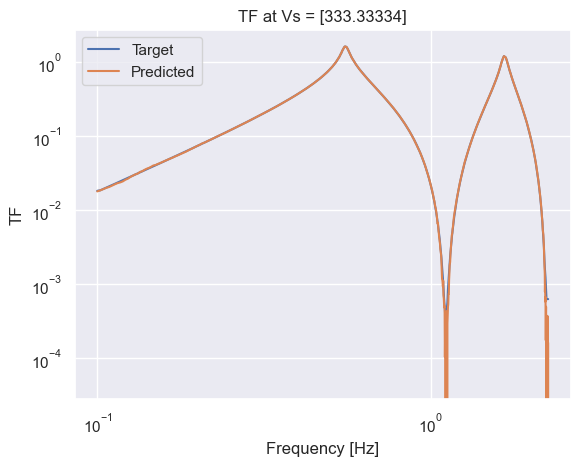

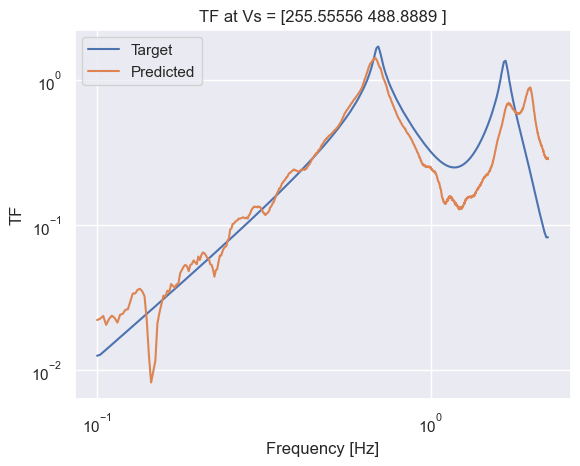

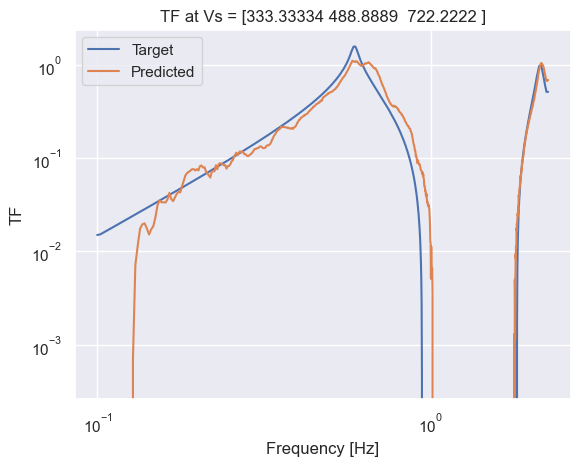

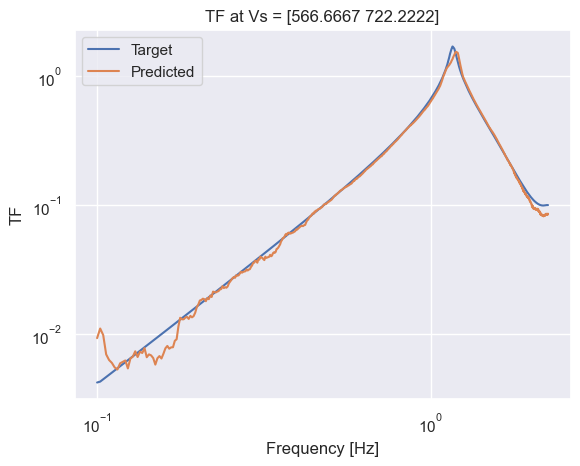

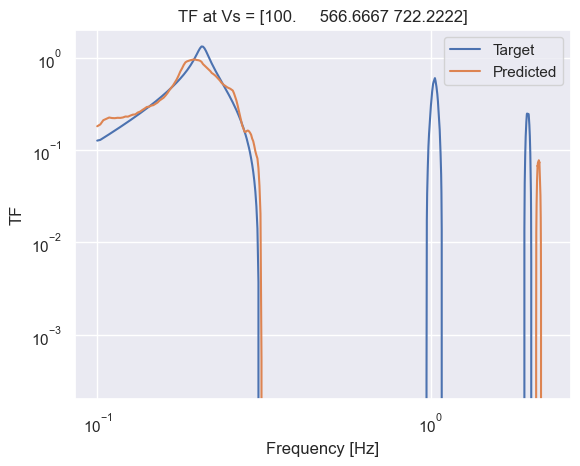

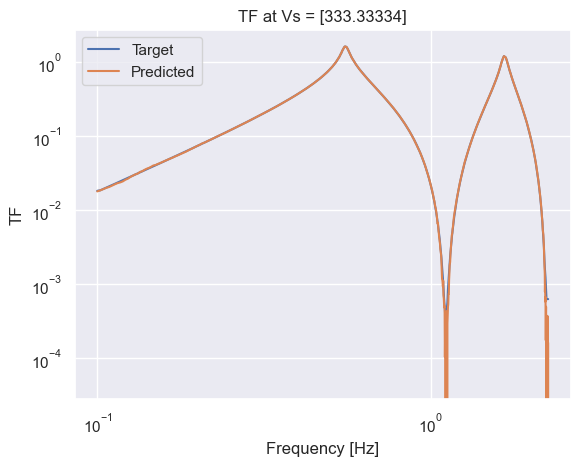

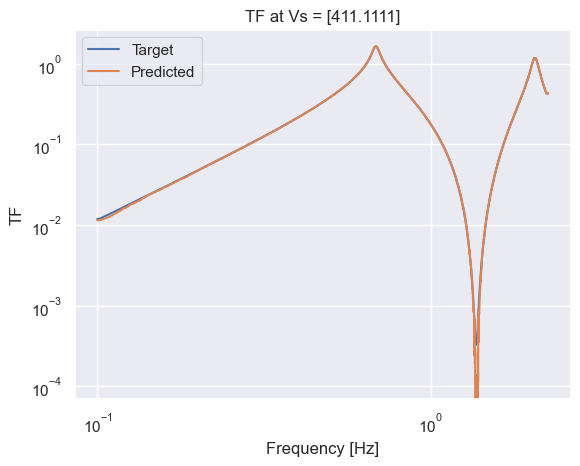

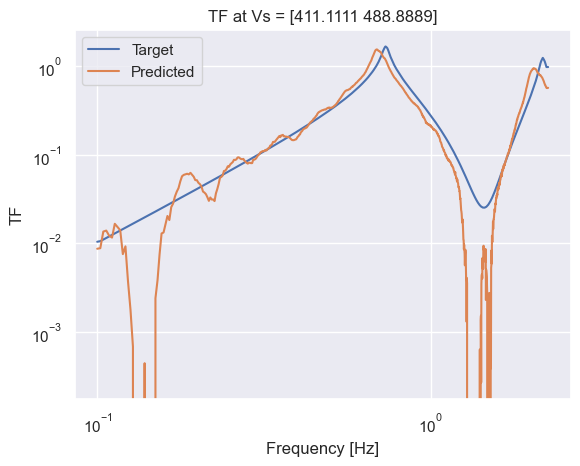

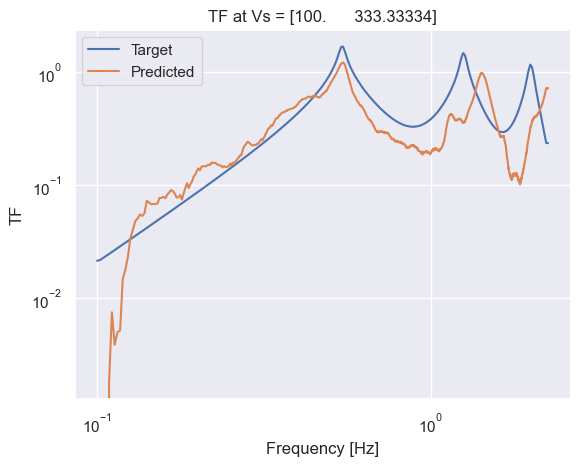

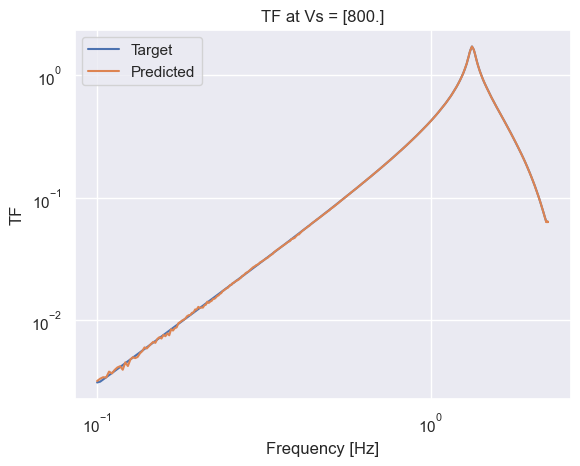

In [197]:
for i in range(target.shape[0]):
    plt.loglog(freq_data_2, target[i,:], label="Target")
    plt.loglog(freq_data_2, predicted[i,:], label="Predicted")
    plt.xlabel("Frequency [Hz]")
    plt.ylabel("TF")
    plt.title("TF at Vs = " + str(np.unique(Vs_data[i,0]))) 
    plt.legend()
    plt.show()

    if i == 10:
        break

# Checking

In [198]:
# Create a lodaer for the whole dataset
all_loader = DataLoader(dataset, batch_size=1, shuffle=False)

correlations = []
Vs_range = []
predicted = []
target = []

with torch.no_grad():
    for X, y in all_loader:
        X, y = X.to(device), y.to(device)
        y_pred = model(X, device)
        correlations.append(pearsonr(y.cpu().numpy().flatten(), y_pred.cpu().numpy().flatten())[0])
        Vs_range.append(X.cpu().numpy().flatten().mean())
        predicted.append(y_pred.cpu().numpy().squeeze())
        target.append(y.cpu().numpy().squeeze())

correlations = np.array(correlations)
Vs_range = np.array(Vs_range)
predicted = np.array(predicted)
target = np.array(target)

Text(0, 0.5, 'Correlation factor')

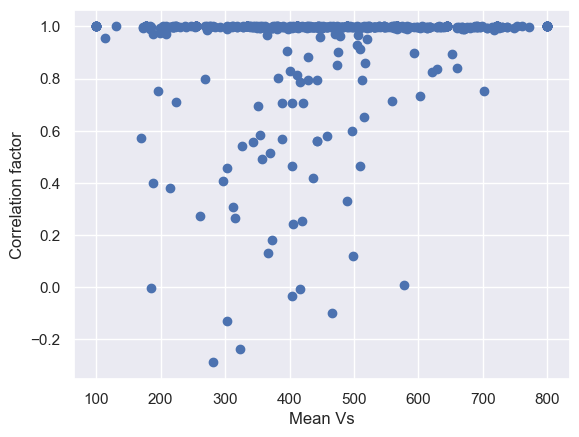

In [202]:
plt.scatter(Vs_range,correlations)
plt.xlabel("Mean Vs")
plt.ylabel("Correlation factor")

In [200]:
# Save model
#torch.save(model.state_dict(), "model_CNN_RNN.pt")

In [201]:
# 